# 7-1장 Learning_rate 조절!

* 모델링하는 과정에 우리는 여러 난관에 부딪힐 수도 있다.
* 그럴 때 이 부분들을 체크하면 꽤 많은 도움이 될 수도 있다.

* 1) learning_rate(학습률)
* 2) data preprocessing(데이터 전처리)
* 3) Overfitting(과적합)

### 1) Learning_rate[학습률]

* 학습률은 우리가 Hypothesis, Cost를 구성하면서 자주 본 단어다.
* Gradient Descent로 함수의 기울기를 파악해 기존의 Weight값에 변화를 주는 과정에 사용하는 값이다.
* 이 learning_rate에 적합한 값을 넣지 않으면...

[![ch7-1.png](https://i.postimg.cc/HsK7C0kC/ch7-1.png)](https://postimg.cc/CzGKGq8v)

* 처음에는 잘 내려오다가도 어느 지점부터
* 적절한 최소의 Cost값을 구하지 못하고 튕겨져 나올(overshooting) 것이다.
* 반대로...

[![ch7-2.png](https://i.postimg.cc/rmQ7dwD5/ch7-2.png)](https://postimg.cc/8JfZ9DBC)

* learning_rate가 너무 작으면 최적의 Cost값을 구하기도 전에
* 내가 지쳐 쓰러질 것이다.

[![ch7-3.png](https://i.postimg.cc/52hK7kYY/ch7-3.png)](https://postimg.cc/gxKKrsKm)

>

* 좋은 learning rate를 찾으면 epoch를 돌리면 돌릴수록 Cost값이 내려간다.
* 반면 나쁜 learning rate는 epoch를 돌리면 돌릴수록 Cost값이 커지거나, 더이상 줄어들지 않는다.

[![ch7-4.png](https://i.postimg.cc/5Nqwd7RQ/ch7-4.png)](https://postimg.cc/Ln5qjTRm)

* 그래서 우리는 Learning Decay라는 것을 사용할 거다.
* epochs를 돌리면서 적절한 learning rate를 찾는 것!!!
* 특정 시점마다 설정한 k값을 learning_rate에 곱하면서 learning_rate를 감소시키는 것!!!

>

### 실제로 데이터를 불러와서 실험해보자

In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

2.0.0-alpha0


In [2]:
tf.random.set_seed(777) # 값 고정

* 일단 우리가 6장에서 활용했던 데이터를 가져오자
* X값은 배열이 3개인 3차원 배열이다.
* Y값은 3종류로 3개의 클래스를 구분하는 예제!

In [3]:
x_train = [[1, 2, 1],
          [1, 3, 2],
          [1, 3, 4],
          [1, 5, 5],
          [1, 7, 5],
          [1, 2, 5],
          [1, 6, 6],
          [1, 7, 7]]

y_train = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1],
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          [1, 0, 0],
          [1, 0, 0]]

x_test = [[2, 1, 1],
          [3, 1, 2],
          [3, 3, 4]]
y_test = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1]]

In [4]:
x1 = [x[0] for x in x_train] # x_train의 첫 번째 인덱스 값 모두 x1에 집어넣기
x2 = [x[1] for x in x_train] # x_train의 두 번째 인덱스 값 모두 x2에 집어넣기
x3 = [x[2] for x in x_train] # x_train의 세 번째 인덱스 값 모두 x3에 집어넣기

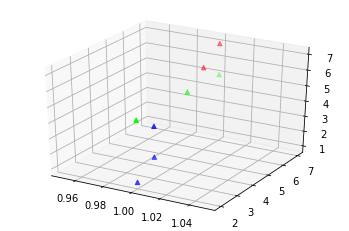

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x1, x2, x3, c = y_train, marker = '^')

* 우리는 Classifier를 통해 저 3종류의 값을 분류해야 한다.
* 이곳에 test 데이터를 넣어보자.

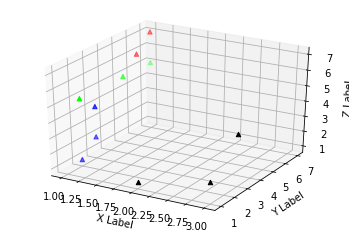

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x1, x2, x3, c = y_train, marker = '^')

# 요개 test 데이터
ax.scatter(x_test[0][0], x_test[0][1], x_test[0][2], c="black", marker='^')
ax.scatter(x_test[1][0], x_test[1][1], x_test[1][2], c="black", marker='^')
ax.scatter(x_test[2][0], x_test[2][1], x_test[2][2], c="black", marker='^')

# 각 축에 이름 써주고
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### 모델링을 해볼까요.

* 모델링을 위한 데이터 값 설정

In [7]:
# x_train, y_train으로 slicing한 값들을 dataset으로 합쳐주고, 그중 batch()안의 개수만큼 가져다 쓴다.
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

In [8]:
# 초기 W, b값 설정
W = tf.Variable(tf.random.normal((3, 3)))
b = tf.Variable(tf.random.normal((3, )))

In [9]:
# Softmax 함수 기반의 Hypothesis 설정
def softmax_fn(features):
    hypothesis = tf.nn.softmax(tf.matmul(features, W) + b)
    return hypothesis

In [10]:
# Cost 값 설정
def cost_fn(hypothesis, features, labels):
    cost = tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(hypothesis), axis = 1))
    return cost

### Learning Decay를 통해 Learning Rate 값을 조정

* learining decay를 위해서 우리는 5개의 파라미터를 설정해야 한다.

* 1. starter_learning_rate = 초기 learning rate 값
* 2. global_step = 현재 학습횟수
* 3. 1000: 곱할 횟수 정의
* 4. 0.96: 기존 learning rate에 곱할 값
* 5. 적용유무 decayed_learning_rate = learning_rate * decay_rate^(global_step / decay_steps)

In [11]:
is_decay = True
starter_learning_rate = 0.1

# 만약 is_decay라면
if(is_decay):
# learning_rate를 다음과 같이 조절해줘
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = starter_learning_rate, # starter_learning_rate
                                                                  decay_steps = 1000,                             # 
                                                                  decay_rate = 0.96,
                                                                  staircase = True)
    
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    
# 먄약 is_decay가 아니라면
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate = starter_learning_rate)

#### Gradient Descent를 설정

In [12]:
def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = cost_fn(softmax_fn(features), features, labels)
    return tape.gradient(loss_value, [W, b])

#### 가설(hypothesis)와 실제값(y) 비교로 Accuracy(정확도) 측정

In [13]:
def accuracy_fn(hypothesis, labels):
    prediction = tf.argmax(hypothesis, 1)
    is_correct = tf.equal(prediction, tf.argmax(labels, 1))     # 실제값도 prediction 처럼 따로 정의할 수 있겠지만
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))  # 하지 않고 그냥 넣었네
    return accuracy

#### Tensorflow로 학습 진행

In [14]:
EPOCHS = 1001 # 1001번의 순환

for step in range(EPOCHS):
    for features, labels in iter(dataset):
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads = grad(softmax_fn(features), features, labels)
        optimizer.apply_gradients(grads_and_vars = zip(grads, [W, b]))
        
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, cost_fn(softmax_fn(features), features, labels)))

Iter: 0, Loss: 7.8510
Iter: 100, Loss: 0.6915
Iter: 200, Loss: 0.5892
Iter: 300, Loss: 0.5326
Iter: 400, Loss: 0.4927
Iter: 500, Loss: 0.4615
Iter: 600, Loss: 0.4358
Iter: 700, Loss: 0.4139
Iter: 800, Loss: 0.3951
Iter: 900, Loss: 0.3785
Iter: 1000, Loss: 0.3638


* Q.3번째 - 4번째 사이 구간에 미리 데이터값을 실수로 바꾼 후에
* 위와 같은 모델을 돌리면 Loss값이 미세하게 다르다.
* 의미있는 이유가 있을끼...?!?!

#### x_train = tf.cast(x_train, tf.float32)
#### y_train = tf.cast(y_train, tf.float32)

#### x_test = tf.cast(x_test, tf.float32)
#### y_test = tf.cast(y_test, tf.float32)

#### test 데이터에 대한 Accuracy는?

In [48]:
x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.float32)

test_acc = accuracy_fn(softmax_fn(x_test),y_test)
print("Testset Accuracy: {:.4f}".format(test_acc))

Testset Accuracy: 1.0000
